# Generate set of administrative regions to use in exposure grid
- The idea here is to get a globally comprehensive set of administrative boundaries at the `adm1` level or higher if the `adm1` level is not available
- Use `adm1` if available and `adm0` if not

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

import geopandas as gpd
import pandas as pd
from shapely.errors import ShapelyDeprecationWarning
from sliiders import settings as sset
from sliiders import spatial
from sliiders.io import read_shapefile, save_geoparquet, save_shapefile

## Read full `adm0` and `adm1` sets

In [3]:
adm0 = gpd.read_parquet(sset.PATH_GADM_ADM0_INT)
adm1 = gpd.read_parquet(sset.PATH_GADM_ADM1_INT)

# Filter out excluded ISOs
excluded_isos = sset.EXCLUDED_ISOS
adm0 = adm0.drop(excluded_isos, errors="ignore")
adm1 = adm1[~adm1["GID_0"].isin(excluded_isos)]

#### Select only countries in `adm0` that do not appear in the `adm1` set, to be included as intermediate `adm1` regions

In [4]:
adm0_as_adm1 = adm0.drop(adm1.GID_0.unique())

#### Concatenate all `adm1` regions

In [5]:
# load ocean shapefile
ocean_and_caspian = read_shapefile(sset.PATH_NATEARTH_OCEAN)
ocean_and_caspian = ocean_and_caspian.explode(index_parts=False)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message=".*Geometry is in a geographic CRS.*")
    ocean_and_caspian["area"] = ocean_and_caspian.area

# Sort so that ocean is first, Caspian is second
ocean_and_caspian = ocean_and_caspian.sort_values("area", ascending=False)
ocean_shape = ocean_and_caspian.geometry.values[0]

In [6]:
# save no-caspian file
save_geoparquet(
    gpd.GeoDataFrame({"geometry": [ocean_shape]}, geometry="geometry"),
    sset.PATH_NATEARTH_OCEAN_NOCASPIAN,
)

/home/jovyan/git-repos/sliiders/sliiders/io.py:67: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  obj.to_parquet(_path, **kwargs)


In [9]:
full = pd.concat((adm0_as_adm1.geometry, adm1.geometry)).to_frame("geometry")

full["ISO"] = full.index.str.split(".").str[0]
full.index.name = "adm1"
assert full.index.is_unique
seg_centroids = gpd.read_parquet(sset.PATH_SEG_CENTROIDS, columns=["geometry"]).geometry
coastlines = gpd.read_parquet(sset.PATH_GEOG_COASTLINES, columns=["geometry"]).geometry

Generating global Voronoi shapes for regions...
...Subdividing region grid to ease computation


  0%|          | 0/363 [00:00<?, ?it/s]

...Creating Voronoi generator points
...Creating Voronoi diagram from generator points


  0%|          | 0/1779 [00:00<?, ?it/s]

...Revmoving already attributed land from voronoi


  0%|          | 0/1779 [00:00<?, ?it/s]

...stitching Voronoi with already attributed land
...cleaning Voronois


  0%|          | 0/8 [00:00<?, ?it/s]

Assigning countries to segment centroids...
Generating within-country Voronoi shapes for segment centroids...
ABW AGO AIA ALA ALB ARE ARG ASM ATF ATG AUS BEL BEN BES BGD BGR BHR BHS BIH BLM BLZ BMU BRA BRB BRN BVT CAN CCK CHL CHN CIV CMR COD COG COK COL COM CPV CRI CUB CUW CXR CYM CYP DEU DJI DMA DNK DOM DZA ECU EGY ERI ESH ESP EST FIN FJI FLK FRA FRO FSM GAB GBR GEO GGY GHA GIB GIN GLP GMB GNB GNQ GRC GRD GRL GTM GUF GUM GUY HKG HMD HND HRV HTI IDN IMN IND IOT IRL IRN IRQ ISL ISR ITA JAM JEY JOR JPN KEN KHM KIR KNA KOR KWT LBN LBR LBY LCA LKA LTU LVA MAC MAF MAR MCO MDG MDV MEX MHL MLT MMR MNE MNP MOZ MRT MSR MTQ MUS MYS MYT NAM NCL NFK NGA NIC NIU NLD NOR NRU NZL OMN PAK PAN PCN PER PHL PLW PNG POL PRI PRK PRT PSE PYF QAT REU ROU RUS SAU SDN SEN SGP SGS SHN SJM SLB SLE SLV SOM SPM STP SUR SVN SWE SXM SYC SYR TCA TGO THA TKL TLS TON TTO TUN TUR TUV TWN TZA UKR UMI URY USA VCT VEN VGB VIR VNM VUT WLF WSM XAD XCL XPI XSP YEM ZAF ZNC Generating country-level coastlines...
Assigning segme

  0%|          | 0/209 [00:00<?, ?it/s]

ABW AGO AIA ALA ALB ARE ARG ASM ATF ATG AUS BEL BEN BES BGD BGR BHR BHS BIH BLM BLZ BMU BRA BRB BRN BVT CAN CCK CHL CHN CIV CMR COD COG COK COL COM CPV CRI CUB CUW CXR CYM CYP DEU DJI DMA DNK DOM DZA ECU EGY ERI ESH ESP EST FIN FJI FLK FRA FRO FSM GAB GBR GEO GGY GHA GIB GIN GLP GMB GNB GNQ GRC GRD GRL GTM GUF GUM GUY HKG HMD HND HRV HTI IDN IMN IND IOT IRL IRN IRQ ISL ISR ITA JAM JEY JOR JPN KEN KHM KIR KNA KOR KWT LBN LBR LBY LCA LKA LTU LVA MAC MAF MAR MCO MDG MDV MEX MHL MLT MMR MNE MNP MOZ MRT MSR MTQ MUS MYS MYT NAM NCL NFK NGA NIC NIU NLD NOR NRU NZL OMN PAK PAN PCN PER PHL PLW PNG POL PRI PRK PRT PSE PYF QAT REU ROU RUS SAU SDN SEN SGP SGS SHN SJM SLB SLE SLV SOM SPM STP SUR SVN SWE SXM SYC SYR TCA TGO THA TKL TLS TON TTO TUN TUR TUV TWN TZA UKR UMI URY USA VCT VEN VGB VIR VNM VUT WLF WSM XAD XCL XPI XSP YEM ZAF ZNC 

  0%|          | 0/45 [00:00<?, ?it/s]

AFG AND ARM AUT AZE BDI BFA BLR BOL BTN BWA CAF CHE CZE ETH HUN KAZ KGZ LAO LIE LSO LUX MDA MKD MLI MNG MWI NER NPL PRY RWA SMR SRB SSD SVK SWZ TCD TJK TKM UGA UZB VAT XKO ZMB ZWE 

  0%|          | 0/8 [00:00<?, ?it/s]

Removing sliver geometries...


/home/jovyan/git-repos/sliiders/sliiders/spatial.py:2451: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded = df.sort_index().explode()
/home/jovyan/git-repos/sliiders/sliiders/spatial.py:2452: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return exploded[exploded.area > min_sq_degrees].dissolve(colname)
/home/jovyan/git-repos/sliiders/sliiders/spatial.py:2451: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded = df.sort_index().explode()
/home/jovyan/git-repos/sliiders/sliiders/spatial.py:2452:

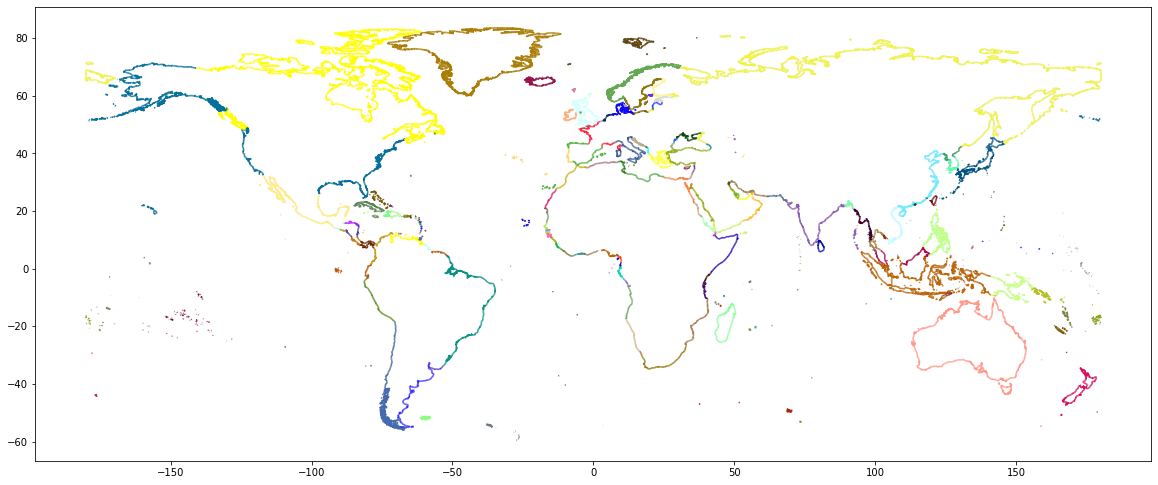

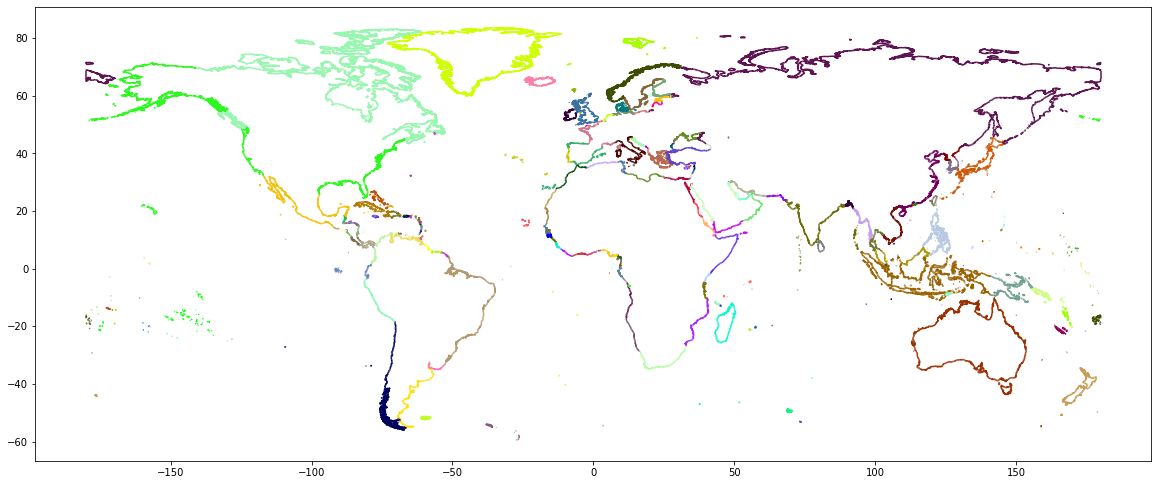

In [14]:
with warnings.catch_warnings():
    try:
        warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
        out, adm0 = spatial.create_overlay_voronois(
            full, seg_centroids, coastlines, ocean_shape, "seg_adm", plot=True
        )
    except Exception as e:
        test = e
        raise

In [15]:
save_geoparquet(out, sset.PATH_SEG_REGION_VORONOI_INTERSECTIONS)
save_geoparquet(adm0, sset.PATH_GADM_ADM0_VORONOI)
save_shapefile(out, sset.PATH_SEG_REGION_VORONOI_INTERSECTIONS_SHP)

/home/jovyan/git-repos/sliiders/sliiders/io.py:74: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  obj.to_parquet(_path, **kwargs)
/home/jovyan/git-repos/sliiders/sliiders/io.py:74: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in 